In [5]:
from utils import *

In [1]:
# pip install larq

In [2]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist, fashion_mnist, cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, Flatten, Conv2D, AveragePooling2D, MaxPooling2D
from tensorflow.keras.utils import *
from kerassurgeon import Surgeon
import larq as lq

from tensorflow.python.framework.ops import disable_eager_execution

disable_eager_execution()
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import time
import pandas as pd
import os

INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [3]:
import larq as lq

from tensorflow.python.framework.ops import disable_eager_execution

disable_eager_execution()

# Pruning - definicja metod

https://blog.dataiku.com/making-neural-networks-smaller-for-better-deployment-solving-the-size-problem-of-cnns-using-network-pruning-with-keras

In [4]:
def get_filter_weights(model, layer=None):
    """function to return weights array for one or all conv layers of a Keras model"""
    if layer or layer == 0:
        weight_array = model.layers[layer].get_weights()[0]
    else:
        weights = [model.layers[layer_ix].get_weights()[0] for layer_ix in range(1, len(model.layers)) \
                   if 'conv' in model.layers[layer_ix].name or 'input_1' in model.layers[layer_ix].name]
        weight_array = [np.array([[[[10000]]]])] + [np.array(i) for i in weights]
    return weight_array


def get_filters_l1(model, layer=None):
    """Returns L1 norm of a Keras model filters at a given conv layer, if layer=None, returns a matrix of norms
model is a Keras model"""
    if layer or layer == 0:
        weights = get_filter_weights(model, layer)
        num_filter = len(weights[0, 0, 0, :])
        norms_dict = {}
        norms = []
        for i in range(num_filter):
            l1_norm = np.sum(abs(weights[:, :, :, i]))
            norms.append(l1_norm)
    else:
        weights = get_filter_weights(model)
        max_kernels = max([layr.shape[3] for layr in weights])
        norms = np.empty((len(weights), max_kernels))
        norms[:] = np.NaN
        for layer_ix in range(len(weights)):
            # compute norm of the filters
            kernel_size = weights[layer_ix][:, :, :, 0].size
            nb_filters = weights[layer_ix].shape[3]
            kernels = weights[layer_ix]
            l1 = [np.sum(abs(kernels[:, :, :, i])) for i in range(nb_filters)]
            # divide by shape of the filters
            l1 = np.array(l1) / kernel_size
            norms[layer_ix, :nb_filters] = l1
    return norms


def compute_pruned_count(model, perc=0.1, layer=None):
    if layer is not None:
        nb_filters = model.layers[layer].output_shape[3]
    else:
        nb_filters = np.sum([model.layers[i].output_shape[-1] for i, layer in enumerate(model.layers)
                             if 'conv' in model.layers[i].name and 'input' not in model.layers[i].name])
    n_pruned = int(np.floor(perc * nb_filters))
    return n_pruned


def smallest_indices(array, N):
    idx = array.ravel().argsort()[:N]
    return np.stack(np.unravel_index(idx, array.shape)).T



def prune_one_layer(model, pruned_indexes, layer_ix, opt):
    """Prunes one layer based on a Keras Model, layer index 
    and indexes of filters to prune"""
    model_pruned = delete_channels(model, model.layers[layer_ix], pruned_indexes)
    model_pruned.compile(loss='categorical_crossentropy',
                         optimizer=opt,
                         metrics=['accuracy'])
    return model_pruned


def prune_multiple_layers(model, pruned_matrix, opt):
    """Prunes several layers based on a Keras Model, layer index and matrix of indexes of filters to prune"""
    conv_indexes = [i for i, v in enumerate(model.layers) if 'conv' in v.name]
    layers_to_prune = np.unique(pruned_matrix[:, 0])
    surgeon = Surgeon(model, copy=True)
    to_prune = pruned_matrix 
    to_prune[:, 0] = np.array([conv_indexes[i] for i in to_prune[:, 0]])
    layers_to_prune = np.unique(to_prune[:, 0])
    for layer_ix in layers_to_prune:
        if layer_ix == 0 and 'input' in model.layers[layer_ix].name:
            continue
        pruned_filters = [x[1] for x in to_prune if x[0] == layer_ix]
        pruned_layer = model.layers[layer_ix]
        surgeon.add_job('delete_channels', pruned_layer, channels=pruned_filters)
    model_pruned = surgeon.operate()
    model_pruned.compile(loss='categorical_crossentropy',
                         optimizer=opt,
                         metrics=['accuracy'])
    return model_pruned


def prune_model(model, perc, opt, method='l1', layer=None):
    """Prune a Keras model using different methods
    Arguments:
        model: Keras Model object
        perc: a float between 0 and 1
        method: method to prune, can be one of ['l1','apoz']
    Returns:
        A pruned Keras Model object
    
    """
    assert method in ['l1','apoz','random'], "Invalid pruning method"
    assert perc >=0, "Invalid pruning percentage"
    if perc < 1:
        n_pruned = compute_pruned_count(model, perc, layer)
    else:
        n_pruned = int(perc)
    print(n_pruned)
    if method =='l1':
        to_prune = smallest_indices(get_filters_l1(model, layer), n_pruned)    
    if layer is not None:
        model_pruned = prune_one_layer(model, to_prune, layer, opt)
    else:
        model_pruned = prune_multiple_layers(model, to_prune, opt)
    return model_pruned

def test_model_accuracy(tflite_model, X_test, y_test):
    # Load TFLite model and allocate tensors.
    interpreter = tf.lite.Interpreter(model_path=tflite_model)
    interpreter.allocate_tensors()

    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]
    accuracy = 0
    times = []
    for img, label in zip(X_test, y_test):
        start = time.time()
        interpreter.set_tensor(input_index, [img])

        interpreter.invoke()

        prediction = interpreter.get_tensor(output_index)
        
        times.append(time.time() - start)
        label_is = np.argmax(prediction, axis=-1)[0]
        label_should_be = label
        if label_is == label_should_be:
            accuracy += 1
        
    accuracy /= len(y_test)
    return (accuracy,sum(times)*1000/len(times)) #(accuracy, latency)


# Przygotowanie zbioru danych - Fashion mnist

In [5]:
nb_classes = 10
class_names = ['T-shirt_top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
print("X_train original shape", X_train.shape)
print("y_train original shape", y_train.shape)

X_train original shape (60000, 28, 28)
y_train original shape (60000,)


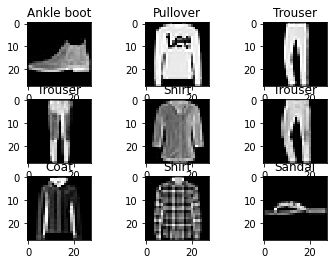

In [6]:
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[i], cmap='gray', interpolation='none')
    plt.title("{}".format(class_names[y_test[i]]))

In [7]:
X_train = X_train.reshape(60000, 28,28,1)
X_test = X_test.reshape(10000, 28,28,1)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

print(nb_classes)

Training matrix shape (60000, 28, 28, 1)
Testing matrix shape (10000, 28, 28, 1)
10


In [8]:
Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test)

# Sieć z 4 warstwami konwolucyjnymi 

Wielowarstwowa sieć konwolucyjna do klasyfikacji ubrań.

In [9]:
model = Sequential([
  Conv2D(64, 3, activation='relu', input_shape=(28, 28, 1)),
  Conv2D(64, 3, activation='relu'),
  MaxPooling2D(pool_size=(2, 2)),  
  Conv2D(128, 3, activation='relu'),
  Conv2D(128, 3, activation='relu'),
  MaxPooling2D(pool_size=(2, 2)),
  Flatten(),
  Dense(16, activation='relu'),
  Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'], 
             experimental_run_tf_function=False)

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0

In [15]:
lq.models.summary(model)

+sequential stats-----------------------------------------------------------------+
| Layer            Input prec.            Outputs  # 32-bit   Memory  32-bit MACs |
|                        (bit)                          x 1     (kB)              |
+---------------------------------------------------------------------------------+
| conv2d                     -   (-1, 26, 26, 64)       640     2.50       389376 |
| conv2d_1                   -   (-1, 24, 24, 64)     36928   144.25     21233664 |
| max_pooling2d              -   (-1, 12, 12, 64)         0        0            0 |
| conv2d_2                   -  (-1, 10, 10, 128)     73856   288.50      7372800 |
| conv2d_3                   -    (-1, 8, 8, 128)    147584   576.50      9437184 |
| max_pooling2d_1            -    (-1, 4, 4, 128)         0        0            0 |
| flatten                    -         (-1, 2048)         0        0            0 |
| dense                      -           (-1, 16)     32784   128.06        

In [14]:
export_dir = 'saved_model'
# model = tf.keras.models.load_model(export_dir)

In [13]:
# model.fit(X_train, Y_train,
#           batch_size=256, epochs=10,
#           verbose=1,
#           validation_data=(X_test, Y_test))

Zapisywanie NN

In [247]:
# model.save(export_dir)

In [16]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

with open("model-base.tflite", "wb") as f:
    f.write(tflite_model)  

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.


Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.


OSError: SavedModel file does not exist at: saved_model/{saved_model.pbtxt|saved_model.pb}

In [249]:
print(test_model_accuracy("model-base.tflite", X_test, y_test))

(0.9125, 0.9715656757354736)


In [250]:
model.count_params()

291962

## Pruning 

In [17]:
model_tmp = model
acc = []
par_count =[]
models = [model_tmp]

acc.append(model_tmp.evaluate(X_test, Y_test)[1])
par_count.append(model_tmp.count_params())
while 1:
    try:
        model_tmp = prune_model(model_tmp, 0.1, opt='adam', method='l1')
    except:
        break
    model_tmp.fit(X_train, Y_train, batch_size=512, epochs=3, verbose=1)
    acc.append(model_tmp.evaluate(X_test, Y_test)[1])
    par_count.append(model_tmp.count_params())
    models.append(model_tmp)

/home/mdobrzanski/anaconda3/envs/iet_env_um/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2424: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


38
Deleting 38/128 channels from layer: conv2d_3
Train on 60000 samples
Epoch 1/3
60000/60000 [==============================] - 5s 91us/sample - loss: 0.9396 - accuracy: 0.6507
Epoch 2/3
60000/60000 [==============================] - 4s 62us/sample - loss: 0.4607 - accuracy: 0.8352
Epoch 3/3
60000/60000 [==============================] - 4s 62us/sample - loss: 0.3834 - accuracy: 0.8628
34
Deleting 1/128 channels from layer: conv2d_2
Deleting 33/90 channels from layer: conv2d_3
Train on 60000 samples
Epoch 1/3
31232/60000 [==============>...............] - ETA: 2s - loss: 0.3798 - accuracy: 0.8637

KeyboardInterrupt: 

Dokładnośc w zależności od liczby parametrów

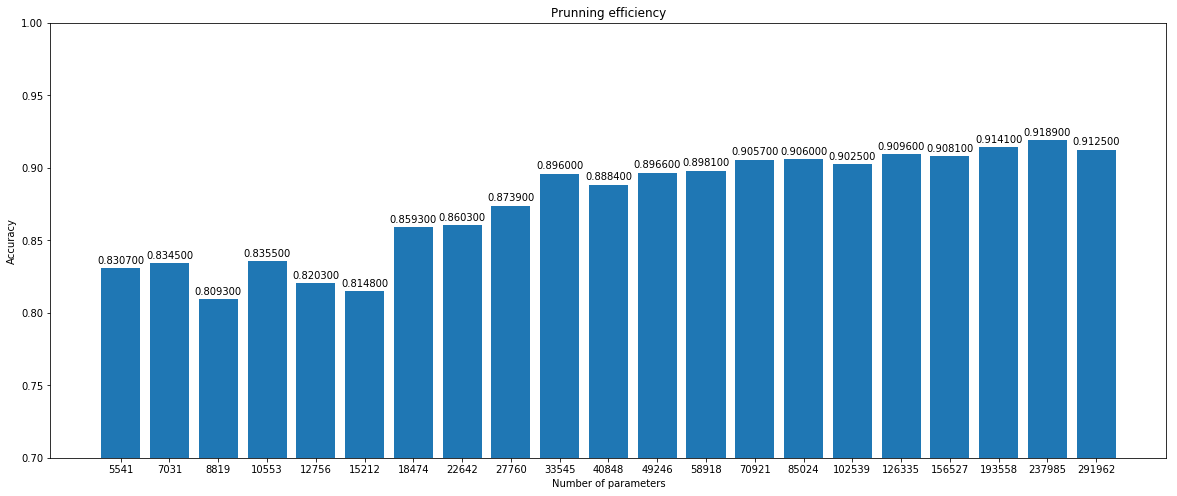

In [30]:
plt.figure(figsize=(20,8))
plot = plt.bar([str(x) for x in par_count][::-1], acc[::-1])
for value in plot:
    height = value.get_height()
    plt.text(value.get_x() + value.get_width()/2.,
             1.002*height,'%f' % height, ha='center', va='bottom')

axes = plt.gca()
axes.set_ylim([0.7,1.0])
plt.title("Prunning efficiency")
plt.xlabel("Number of parameters")
plt.ylabel("Accuracy")
plt.show()

In [66]:
sizes = []
invocation_times =[]

for model_tmp in models:
    export_dir_tmp = 'saved_model_tmp'
    model_tmp.save(export_dir_tmp)

    converter = tf.lite.TFLiteConverter.from_saved_model(export_dir_tmp)
    tflite_model_tmp = converter.convert()

    with open("model-pruned.tflite", "wb") as f:
        f.write(tflite_model_tmp)  

    sizes.append(str(os.stat('model-pruned.tflite').st_size//1024) + 'kb')
    invocation_times.append(test_model_accuracy("model-pruned.tflite", X_test, y_test)[1])

INFO:tensorflow:Assets written to: saved_model_tmp/assets


INFO:tensorflow:Assets written to: saved_model_tmp/assets


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.f

INFO:tensorflow:Assets written to: saved_model_tmp/assets


INFO:tensorflow:Assets written to: saved_model_tmp/assets


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.f

INFO:tensorflow:Assets written to: saved_model_tmp/assets


INFO:tensorflow:Assets written to: saved_model_tmp/assets


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.f

INFO:tensorflow:Assets written to: saved_model_tmp/assets


INFO:tensorflow:Assets written to: saved_model_tmp/assets


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.f

INFO:tensorflow:Assets written to: saved_model_tmp/assets


INFO:tensorflow:Assets written to: saved_model_tmp/assets


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.f

INFO:tensorflow:Assets written to: saved_model_tmp/assets


INFO:tensorflow:Assets written to: saved_model_tmp/assets


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.f

INFO:tensorflow:Assets written to: saved_model_tmp/assets


INFO:tensorflow:Assets written to: saved_model_tmp/assets


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.f

INFO:tensorflow:Assets written to: saved_model_tmp/assets


INFO:tensorflow:Assets written to: saved_model_tmp/assets


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.f

INFO:tensorflow:Assets written to: saved_model_tmp/assets


INFO:tensorflow:Assets written to: saved_model_tmp/assets


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.f

INFO:tensorflow:Assets written to: saved_model_tmp/assets


INFO:tensorflow:Assets written to: saved_model_tmp/assets


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.f

INFO:tensorflow:Assets written to: saved_model_tmp/assets


INFO:tensorflow:Assets written to: saved_model_tmp/assets


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.f

INFO:tensorflow:Assets written to: saved_model_tmp/assets


INFO:tensorflow:Assets written to: saved_model_tmp/assets


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.f

INFO:tensorflow:Assets written to: saved_model_tmp/assets


INFO:tensorflow:Assets written to: saved_model_tmp/assets


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.f

INFO:tensorflow:Assets written to: saved_model_tmp/assets


INFO:tensorflow:Assets written to: saved_model_tmp/assets


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.f

INFO:tensorflow:Assets written to: saved_model_tmp/assets


INFO:tensorflow:Assets written to: saved_model_tmp/assets


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.f

INFO:tensorflow:Assets written to: saved_model_tmp/assets


INFO:tensorflow:Assets written to: saved_model_tmp/assets


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.f

INFO:tensorflow:Assets written to: saved_model_tmp/assets


INFO:tensorflow:Assets written to: saved_model_tmp/assets


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.f

INFO:tensorflow:Assets written to: saved_model_tmp/assets


INFO:tensorflow:Assets written to: saved_model_tmp/assets


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.f

INFO:tensorflow:Assets written to: saved_model_tmp/assets


INFO:tensorflow:Assets written to: saved_model_tmp/assets


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.f

INFO:tensorflow:Assets written to: saved_model_tmp/assets


INFO:tensorflow:Assets written to: saved_model_tmp/assets


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.f

INFO:tensorflow:Assets written to: saved_model_tmp/assets


INFO:tensorflow:Assets written to: saved_model_tmp/assets


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.f

In [32]:
summary = pd.DataFrame(np.array([par_count, acc]).T, columns=['Number of parameters', 'Accuracy'])

summary['Model size'] = sizes
summary['Invocation time'] = invocation_times

summary = summary.sort_values('Number of parameters', ascending=False)

summary.reset_index(inplace=True, drop=True)

In [160]:
summary

,Number of parameters,Accuracy,Model size,Invocation time
0,291962.0,0.9125,1147kb,0.932673
1,237985.0,0.9189,935kb,0.960728
2,193558.0,0.9141,762kb,1.257522
3,156527.0,0.9081,617kb,1.081886
4,126335.0,0.9096,499kb,1.165124
5,102539.0,0.9025,406kb,1.153979
6,85024.0,0.9060,338kb,1.133842
7,70921.0,0.9057,283kb,0.919064
8,58918.0,0.8981,236kb,0.908900
9,49246.0,0.8966,198kb,0.901656


### dodatkowo kwantyzacja 

In [134]:
sizes_q = []
invocation_times_q =[]
acc_q = []
par_count_q =[]

for model_tmp in models:
    
    export_dir_tmp = 'saved_model_tmp'
    model_tmp.save(export_dir_tmp)

    converter = tf.lite.TFLiteConverter.from_saved_model(export_dir_tmp)
    converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
    converter.target_spec.supported_types = [tf.float16]
    tflite_model_tmp = converter.convert()

    with open("model-pruned.tflite", "wb") as f:
        f.write(tflite_model_tmp)  

    sizes_q.append(str(os.stat('model-pruned.tflite').st_size//1024) + 'kb')
    acc_tmp, inv_time = test_model_accuracy("model-pruned.tflite", X_test, y_test)
    invocation_times_q.append(inv_time)
    acc_q.append(acc_tmp)
    par_count_q.append(model_tmp.count_params())

INFO:tensorflow:Assets written to: saved_model_tmp/assets


INFO:tensorflow:Assets written to: saved_model_tmp/assets


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.f

INFO:tensorflow:Assets written to: saved_model_tmp/assets


INFO:tensorflow:Assets written to: saved_model_tmp/assets


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.f

INFO:tensorflow:Assets written to: saved_model_tmp/assets


INFO:tensorflow:Assets written to: saved_model_tmp/assets


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.f

INFO:tensorflow:Assets written to: saved_model_tmp/assets


INFO:tensorflow:Assets written to: saved_model_tmp/assets


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.f

INFO:tensorflow:Assets written to: saved_model_tmp/assets


INFO:tensorflow:Assets written to: saved_model_tmp/assets


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.f

INFO:tensorflow:Assets written to: saved_model_tmp/assets


INFO:tensorflow:Assets written to: saved_model_tmp/assets


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.f

INFO:tensorflow:Assets written to: saved_model_tmp/assets


INFO:tensorflow:Assets written to: saved_model_tmp/assets


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.f

INFO:tensorflow:Assets written to: saved_model_tmp/assets


INFO:tensorflow:Assets written to: saved_model_tmp/assets


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.f

INFO:tensorflow:Assets written to: saved_model_tmp/assets


INFO:tensorflow:Assets written to: saved_model_tmp/assets


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.f

INFO:tensorflow:Assets written to: saved_model_tmp/assets


INFO:tensorflow:Assets written to: saved_model_tmp/assets


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.f

INFO:tensorflow:Assets written to: saved_model_tmp/assets


INFO:tensorflow:Assets written to: saved_model_tmp/assets


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.f

INFO:tensorflow:Assets written to: saved_model_tmp/assets


INFO:tensorflow:Assets written to: saved_model_tmp/assets


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.f

INFO:tensorflow:Assets written to: saved_model_tmp/assets


INFO:tensorflow:Assets written to: saved_model_tmp/assets


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.f

INFO:tensorflow:Assets written to: saved_model_tmp/assets


INFO:tensorflow:Assets written to: saved_model_tmp/assets


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.f

INFO:tensorflow:Assets written to: saved_model_tmp/assets


INFO:tensorflow:Assets written to: saved_model_tmp/assets


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.f

INFO:tensorflow:Assets written to: saved_model_tmp/assets


INFO:tensorflow:Assets written to: saved_model_tmp/assets


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.f

INFO:tensorflow:Assets written to: saved_model_tmp/assets


INFO:tensorflow:Assets written to: saved_model_tmp/assets


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.f

INFO:tensorflow:Assets written to: saved_model_tmp/assets


INFO:tensorflow:Assets written to: saved_model_tmp/assets


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.f

INFO:tensorflow:Assets written to: saved_model_tmp/assets


INFO:tensorflow:Assets written to: saved_model_tmp/assets


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.f

INFO:tensorflow:Assets written to: saved_model_tmp/assets


INFO:tensorflow:Assets written to: saved_model_tmp/assets


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.f

INFO:tensorflow:Assets written to: saved_model_tmp/assets


INFO:tensorflow:Assets written to: saved_model_tmp/assets


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 28, 28, 1), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.f

In [153]:
summary_q = pd.DataFrame(np.array([par_count_q, acc_q]).T, columns=['Number of parameters', 'Accuracy'])

summary_q['Model size'] = sizes_q
summary_q['Invocation time'] = invocation_times_q

summary_q = summary_q.sort_values('Number of parameters', ascending=False)

summary_q.reset_index(inplace=True, drop=True)

In [161]:
summary_q

,Number of parameters,Accuracy,Model size,Invocation time
0,291962.0,0.9122,579kb,0.885838
1,237985.0,0.9189,473kb,1.003944
2,193558.0,0.9141,387kb,1.197908
3,156527.0,0.9081,314kb,1.100767
4,126335.0,0.9097,255kb,1.107325
5,102539.0,0.9024,209kb,1.159968
6,85024.0,0.9061,174kb,1.072111
7,70921.0,0.9058,147kb,1.021502
8,58918.0,0.8981,123kb,0.976899
9,49246.0,0.8966,105kb,0.947760


## Ostateczne porównanie accuracy w zależności od wielkości modelu

In [178]:
final_summary = pd.concat([summary_q[['Model size', 'Accuracy']],summary[['Model size', 'Accuracy']]])

final_summary = final_summary.sort_values('Model size', key=lambda x: x.apply(lambda x: int(x[:-2])),
                                          ascending=True)

final_summary.reset_index(inplace=True, drop=True)

In [199]:
final_summary

,Model size,Accuracy
0,20kb,0.8402
1,22kb,0.8344
2,26kb,0.8096
3,28kb,0.8307
4,29kb,0.8354
5,33kb,0.8345
6,33kb,0.8203
7,38kb,0.8148
8,40kb,0.8093
9,45kb,0.8592


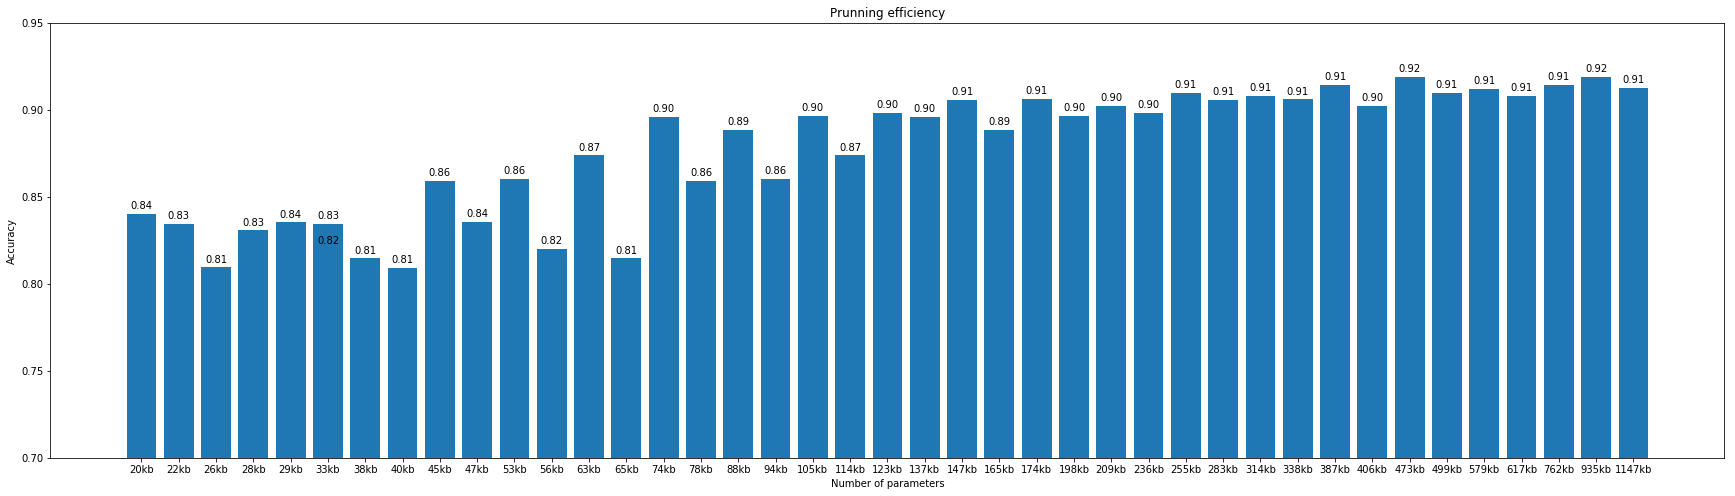

In [215]:
plt.figure(figsize=(30,8))
plot = plt.bar(final_summary['Model size'],
               final_summary['Accuracy'])
for value in plot:
    height = value.get_height()
    plt.text(value.get_x() + value.get_width()/2.,
             1.002*height,'%.2f' % height, ha='center', va='bottom')

axes = plt.gca()
axes.set_ylim([0.7,0.95])
plt.title("Prunning efficiency")
plt.xlabel("Number of parameters")
plt.ylabel("Accuracy")
plt.show()

# Pruning na przetrenowanej wczesniej architekturze

In [16]:
def prune_multiple_layers(model, pruned_matrix, opt):
    """Prunes several layers based on a Keras Model, layer index and matrix of indexes of filters to prune"""
    conv_indexes = [i for i, v in enumerate(model.layers) if 'conv' in v.name]
    layers_to_prune = np.unique(pruned_matrix[:, 0])
    surgeon = Surgeon(model, copy=True)
    to_prune = pruned_matrix 
    to_prune[:, 0] = np.array([conv_indexes[i-1] for i in to_prune[:, 0]])
    layers_to_prune = np.unique(to_prune[:, 0])
    for layer_ix in layers_to_prune:
        if layer_ix == 0 and 'input' in model.layers[layer_ix].name:
            continue
        pruned_filters = [x[1] for x in to_prune if x[0] == layer_ix]
        pruned_layer = model.layers[layer_ix]
        surgeon.add_job('delete_channels', pruned_layer, channels=pruned_filters)
    model_pruned = surgeon.operate()
    model_pruned.compile(loss='categorical_crossentropy',
                         optimizer=opt,
                         metrics=['accuracy'])
    return model_pruned

# Przygotowanie zbioru cifar10

In [17]:
nb_classes = 10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog',
               'horse', 'ship', 'truck']

(X_train, y_train), (X_test, y_test) = cifar10.load_data()
print("X_train original shape", X_train.shape)
print("y_train original shape", y_train.shape)

X_train original shape (50000, 32, 32, 3)
y_train original shape (50000, 1)


In [18]:
y_train = y_train.reshape((y_train.shape[0],))
y_test = y_test.reshape((y_test.shape[0],))

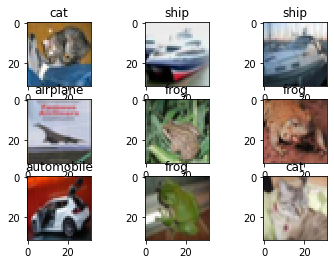

In [19]:
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[i], interpolation='none')
    plt.title("{}".format(class_names[y_test[i]]))

In [20]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

print(nb_classes)

Training matrix shape (50000, 32, 32, 3)
Testing matrix shape (10000, 32, 32, 3)
10


In [11]:
Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test)

# VGG16 - przygotowanie modelu

In [1]:
from tensorflow.keras.applications.vgg16 import VGG16

base_model = VGG16(input_shape = (32, 32, 3),
    include_top = False, weights = 'imagenet')

In [2]:
for layer in base_model.layers:
    layer.trainable = False

In [6]:
# Flatten the output layer to 1 dimension
x = Flatten()(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = Dense(512, activation='relu')(x)

# Add a dropout rate of 0.2
x = Dropout(0.2)(x)

# Add a final sigmoid layer for classification
x = Dense(10, activation='sigmoid')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'], 
             experimental_run_tf_function=False)

In [7]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

In [8]:
lq.models.summary(model)

+model stats--------------------------------------------------------------------+
| Layer         Input prec.            Outputs  # 32-bit    Memory  32-bit MACs |
|                     (bit)                          x 1      (kB)              |
+-------------------------------------------------------------------------------+
| input_1                 -    (-1, 32, 32, 3)         0         0            ? |
| block1_conv1            -   (-1, 32, 32, 64)      1792      7.00      1769472 |
| block1_conv2            -   (-1, 32, 32, 64)     36928    144.25     37748736 |
| block1_pool             -   (-1, 16, 16, 64)         0         0            0 |
| block2_conv1            -  (-1, 16, 16, 128)     73856    288.50     18874368 |
| block2_conv2            -  (-1, 16, 16, 128)    147584    576.50     37748736 |
| block2_pool             -    (-1, 8, 8, 128)         0         0            0 |
| block3_conv1            -    (-1, 8, 8, 256)    295168   1153.00     18874368 |
| block3_conv2  

In [16]:
export_dir = 'VGG_model'
model = tf.keras.models.load_model(export_dir)

In [17]:
# model.fit(X_train, Y_train, batch_size=512, epochs=10)

In [18]:
# model.save(export_dir)

In [19]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

with open("model-base.tflite", "wb") as f:
    f.write(tflite_model)  

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.


Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.


INFO:tensorflow:Restoring parameters from VGG_model/variables/variables


INFO:tensorflow:Restoring parameters from VGG_model/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'serving_default', '__saved_model_init_op'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'serving_default', '__saved_model_init_op'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: input_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: input_1


INFO:tensorflow: tensor name: serving_default_input_1:0, shape: (-1, 32, 32, 3), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_input_1:0, shape: (-1, 32, 32, 3), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_3


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_3


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from VGG_model/variables/variables


INFO:tensorflow:Restoring parameters from VGG_model/variables/variables


Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`


Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`


Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


INFO:tensorflow:Restoring parameters from VGG_model/variables/variables


INFO:tensorflow:Restoring parameters from VGG_model/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: input_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: input_1


INFO:tensorflow: tensor name: serving_default_input_1:0, shape: (-1, 32, 32, 3), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_input_1:0, shape: (-1, 32, 32, 3), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_3


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_3


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from VGG_model/variables/variables


INFO:tensorflow:Restoring parameters from VGG_model/variables/variables
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.functio

In [20]:
print(test_model_accuracy("model-base.tflite", X_test, y_test))

(0.6157, 10.00095705986023)


In [21]:
model.count_params()

14982474

## Pruning

In [33]:
model_tmp = tf.keras.models.load_model(export_dir)
for layer in model_tmp.layers:
    model.trainable = True
acc = []
par_count =[]
models = [model_tmp]

acc.append(model_tmp.evaluate(X_test, Y_test)[1])
par_count.append(model_tmp.count_params())
while 1:
    try:
        model_tmp = prune_model(model_tmp, 0.1, opt='adam', method='l1')
    except:
        break
    model_tmp.fit(X_train, Y_train, batch_size=512, epochs=3, verbose=1)
    acc.append(model_tmp.evaluate(X_test, Y_test)[1])
    par_count.append(model_tmp.count_params())
    models.append(model_tmp)

422
Deleting 3/128 channels from layer: block2_conv1
Deleting 1/512 channels from layer: block4_conv1
Deleting 223/512 channels from layer: block4_conv2
Deleting 153/512 channels from layer: block4_conv3
Deleting 5/512 channels from layer: block5_conv1
Deleting 1/512 channels from layer: block5_conv2
Deleting 36/512 channels from layer: block5_conv3
Train on 50000 samples
Epoch 1/3
50000/50000 [==============================] - 11s 221us/sample - loss: 1.3217 - accuracy: 0.5356
Epoch 2/3
50000/50000 [==============================] - 11s 216us/sample - loss: 1.1720 - accuracy: 0.5905
Epoch 3/3
50000/50000 [==============================] - 10s 200us/sample - loss: 1.1194 - accuracy: 0.6088
380
Deleting 2/256 channels from layer: block3_conv2
Deleting 12/511 channels from layer: block4_conv1
Deleting 165/289 channels from layer: block4_conv2
Deleting 83/359 channels from layer: block4_conv3
Deleting 23/507 channels from layer: block5_conv1
Deleting 14/511 channels from layer: block5_con

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


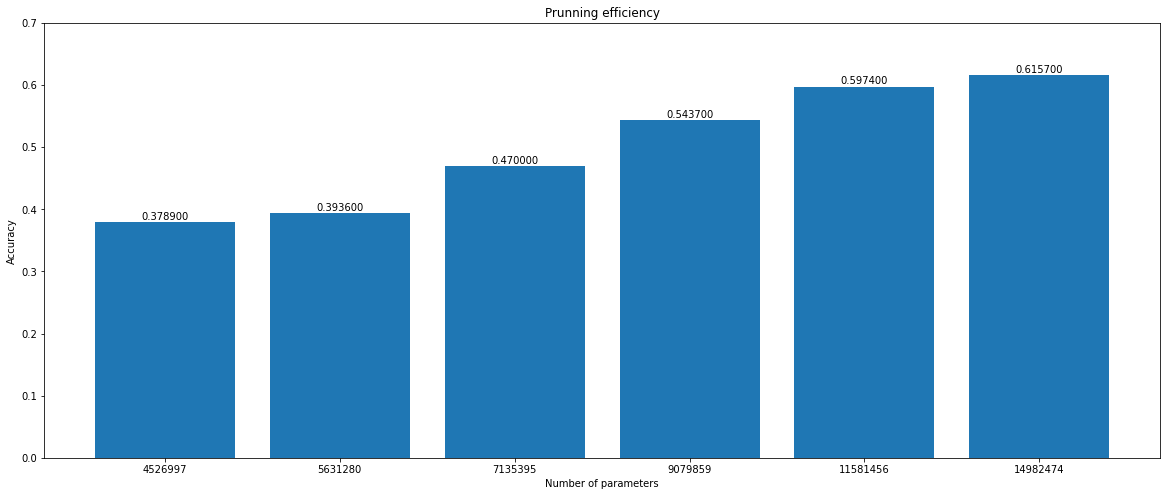

In [36]:
plt.figure(figsize=(20,8))
plot = plt.bar([str(x) for x in par_count][::-1], acc[::-1])
for value in plot:
    height = value.get_height()
    plt.text(value.get_x() + value.get_width()/2.,
             1.002*height,'%f' % height, ha='center', va='bottom')

axes = plt.gca()
axes.set_ylim([0.0,0.7])
plt.title("Prunning efficiency")
plt.xlabel("Number of parameters")
plt.ylabel("Accuracy")
plt.show()

In [37]:
sizes = []
invocation_times =[]

for model_tmp in models:
    export_dir_tmp = 'saved_model_tmp'
    model_tmp.save(export_dir_tmp)

    converter = tf.lite.TFLiteConverter.from_saved_model(export_dir_tmp)
    tflite_model_tmp = converter.convert()

    with open("model-pruned.tflite", "wb") as f:
        f.write(tflite_model_tmp)  

    sizes.append(str(os.stat('model-pruned.tflite').st_size//1024) + 'kb')
    invocation_times.append(test_model_accuracy("model-pruned.tflite", X_test, y_test)[1])

INFO:tensorflow:Assets written to: saved_model_tmp/assets


INFO:tensorflow:Assets written to: saved_model_tmp/assets


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: input_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: input_1


INFO:tensorflow: tensor name: serving_default_input_1:0, shape: (-1, 32, 32, 3), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_input_1:0, shape: (-1, 32, 32, 3), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_3


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_3


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: input_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: input_1


INFO:tensorflow: tensor name: serving_default_input_1:0, shape: (-1, 32, 32, 3), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_input_1:0, shape: (-1, 32, 32, 3), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_3


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_3


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.f

INFO:tensorflow:Assets written to: saved_model_tmp/assets


INFO:tensorflow:Assets written to: saved_model_tmp/assets


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: input_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: input_1


INFO:tensorflow: tensor name: serving_default_input_1:0, shape: (-1, 32, 32, 3), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_input_1:0, shape: (-1, 32, 32, 3), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_3


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_3


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: input_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: input_1


INFO:tensorflow: tensor name: serving_default_input_1:0, shape: (-1, 32, 32, 3), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_input_1:0, shape: (-1, 32, 32, 3), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_3


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_3


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.f

INFO:tensorflow:Assets written to: saved_model_tmp/assets


INFO:tensorflow:Assets written to: saved_model_tmp/assets


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'serving_default', '__saved_model_init_op'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'serving_default', '__saved_model_init_op'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: input_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: input_1


INFO:tensorflow: tensor name: serving_default_input_1:0, shape: (-1, 32, 32, 3), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_input_1:0, shape: (-1, 32, 32, 3), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_3


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_3


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'serving_default', '__saved_model_init_op'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'serving_default', '__saved_model_init_op'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: input_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: input_1


INFO:tensorflow: tensor name: serving_default_input_1:0, shape: (-1, 32, 32, 3), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_input_1:0, shape: (-1, 32, 32, 3), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_3


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_3


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.f

INFO:tensorflow:Assets written to: saved_model_tmp/assets


INFO:tensorflow:Assets written to: saved_model_tmp/assets


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'serving_default', '__saved_model_init_op'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'serving_default', '__saved_model_init_op'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: input_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: input_1


INFO:tensorflow: tensor name: serving_default_input_1:0, shape: (-1, 32, 32, 3), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_input_1:0, shape: (-1, 32, 32, 3), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_3


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_3


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'serving_default', '__saved_model_init_op'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'serving_default', '__saved_model_init_op'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: input_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: input_1


INFO:tensorflow: tensor name: serving_default_input_1:0, shape: (-1, 32, 32, 3), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_input_1:0, shape: (-1, 32, 32, 3), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_3


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_3


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.f

INFO:tensorflow:Assets written to: saved_model_tmp/assets


INFO:tensorflow:Assets written to: saved_model_tmp/assets


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: input_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: input_1


INFO:tensorflow: tensor name: serving_default_input_1:0, shape: (-1, 32, 32, 3), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_input_1:0, shape: (-1, 32, 32, 3), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_3


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_3


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'serving_default', '__saved_model_init_op'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'serving_default', '__saved_model_init_op'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: input_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: input_1


INFO:tensorflow: tensor name: serving_default_input_1:0, shape: (-1, 32, 32, 3), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_input_1:0, shape: (-1, 32, 32, 3), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_3


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_3


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.f

INFO:tensorflow:Assets written to: saved_model_tmp/assets


INFO:tensorflow:Assets written to: saved_model_tmp/assets


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: input_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: input_1


INFO:tensorflow: tensor name: serving_default_input_1:0, shape: (-1, 32, 32, 3), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_input_1:0, shape: (-1, 32, 32, 3), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_3


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_3


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'serving_default', '__saved_model_init_op'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'serving_default', '__saved_model_init_op'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: input_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: input_1


INFO:tensorflow: tensor name: serving_default_input_1:0, shape: (-1, 32, 32, 3), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_input_1:0, shape: (-1, 32, 32, 3), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_3


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_3


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.f

In [38]:
summary = pd.DataFrame(np.array([par_count, acc]).T, columns=['Number of parameters', 'Accuracy'])

summary['Model size'] = sizes
summary['Invocation time'] = invocation_times

summary = summary.sort_values('Number of parameters', ascending=False)

summary.reset_index(inplace=True, drop=True)

In [40]:
summary

,Number of parameters,Accuracy,Model size,Invocation time
0,14982474.0,0.6157,58541kb,10.636356
1,11581456.0,0.5974,45256kb,9.998700
2,9079859.0,0.5437,35484kb,8.898129
3,7135395.0,0.4700,27888kb,7.953341
4,5631280.0,0.3936,22013kb,6.636314
5,4526997.0,0.3789,17699kb,5.812174


### dodatkowa kwantyzacja

In [41]:
sizes_q = []
invocation_times_q =[]
acc_q = []
par_count_q =[]

for model_tmp in models:
    
    export_dir_tmp = 'saved_model_tmp'
    model_tmp.save(export_dir_tmp)

    converter = tf.lite.TFLiteConverter.from_saved_model(export_dir_tmp)
    converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
    converter.target_spec.supported_types = [tf.float16]
    tflite_model_tmp = converter.convert()

    with open("model-pruned.tflite", "wb") as f:
        f.write(tflite_model_tmp)  

    sizes_q.append(str(os.stat('model-pruned.tflite').st_size//1024) + 'kb')
    acc_tmp, inv_time = test_model_accuracy("model-pruned.tflite", X_test, y_test)
    invocation_times_q.append(inv_time)
    acc_q.append(acc_tmp)
    par_count_q.append(model_tmp.count_params())

INFO:tensorflow:Assets written to: saved_model_tmp/assets


INFO:tensorflow:Assets written to: saved_model_tmp/assets


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'serving_default', '__saved_model_init_op'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'serving_default', '__saved_model_init_op'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: input_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: input_1


INFO:tensorflow: tensor name: serving_default_input_1:0, shape: (-1, 32, 32, 3), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_input_1:0, shape: (-1, 32, 32, 3), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_3


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_3


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: input_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: input_1


INFO:tensorflow: tensor name: serving_default_input_1:0, shape: (-1, 32, 32, 3), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_input_1:0, shape: (-1, 32, 32, 3), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_3


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_3


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.f

INFO:tensorflow:Assets written to: saved_model_tmp/assets


INFO:tensorflow:Assets written to: saved_model_tmp/assets


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: input_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: input_1


INFO:tensorflow: tensor name: serving_default_input_1:0, shape: (-1, 32, 32, 3), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_input_1:0, shape: (-1, 32, 32, 3), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_3


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_3


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'serving_default', '__saved_model_init_op'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'serving_default', '__saved_model_init_op'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: input_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: input_1


INFO:tensorflow: tensor name: serving_default_input_1:0, shape: (-1, 32, 32, 3), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_input_1:0, shape: (-1, 32, 32, 3), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_3


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_3


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.f

INFO:tensorflow:Assets written to: saved_model_tmp/assets


INFO:tensorflow:Assets written to: saved_model_tmp/assets


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'serving_default', '__saved_model_init_op'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'serving_default', '__saved_model_init_op'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: input_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: input_1


INFO:tensorflow: tensor name: serving_default_input_1:0, shape: (-1, 32, 32, 3), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_input_1:0, shape: (-1, 32, 32, 3), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_3


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_3


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: input_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: input_1


INFO:tensorflow: tensor name: serving_default_input_1:0, shape: (-1, 32, 32, 3), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_input_1:0, shape: (-1, 32, 32, 3), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_3


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_3


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.f

INFO:tensorflow:Assets written to: saved_model_tmp/assets


INFO:tensorflow:Assets written to: saved_model_tmp/assets


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: input_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: input_1


INFO:tensorflow: tensor name: serving_default_input_1:0, shape: (-1, 32, 32, 3), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_input_1:0, shape: (-1, 32, 32, 3), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_3


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_3


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'serving_default', '__saved_model_init_op'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'serving_default', '__saved_model_init_op'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: input_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: input_1


INFO:tensorflow: tensor name: serving_default_input_1:0, shape: (-1, 32, 32, 3), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_input_1:0, shape: (-1, 32, 32, 3), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_3


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_3


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.f

INFO:tensorflow:Assets written to: saved_model_tmp/assets


INFO:tensorflow:Assets written to: saved_model_tmp/assets


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'serving_default', '__saved_model_init_op'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'serving_default', '__saved_model_init_op'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: input_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: input_1


INFO:tensorflow: tensor name: serving_default_input_1:0, shape: (-1, 32, 32, 3), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_input_1:0, shape: (-1, 32, 32, 3), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_3


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_3


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: input_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: input_1


INFO:tensorflow: tensor name: serving_default_input_1:0, shape: (-1, 32, 32, 3), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_input_1:0, shape: (-1, 32, 32, 3), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_3


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_3


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.f

INFO:tensorflow:Assets written to: saved_model_tmp/assets


INFO:tensorflow:Assets written to: saved_model_tmp/assets


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: input_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: input_1


INFO:tensorflow: tensor name: serving_default_input_1:0, shape: (-1, 32, 32, 3), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_input_1:0, shape: (-1, 32, 32, 3), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_3


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_3


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: input_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: input_1


INFO:tensorflow: tensor name: serving_default_input_1:0, shape: (-1, 32, 32, 3), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_input_1:0, shape: (-1, 32, 32, 3), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_3


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_3


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 10), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables


INFO:tensorflow:Restoring parameters from saved_model_tmp/variables/variables
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.f

In [42]:
summary_q = pd.DataFrame(np.array([par_count_q, acc_q]).T, columns=['Number of parameters', 'Accuracy'])

summary_q['Model size'] = sizes_q
summary_q['Invocation time'] = invocation_times_q

summary_q = summary_q.sort_values('Number of parameters', ascending=False)

summary_q.reset_index(inplace=True, drop=True)

In [43]:
summary_q

,Number of parameters,Accuracy,Model size,Invocation time
0,14982474.0,0.6159,29287kb,11.018968
1,11581456.0,0.5977,22644kb,10.494848
2,9079859.0,0.5436,17757kb,8.991304
3,7135395.0,0.4700,13959kb,7.638656
4,5631280.0,0.3935,11022kb,6.837274
5,4526997.0,0.3786,8865kb,6.363489


In [15]:
8865/58541

0.15143232947848517

## Ostateczne porównanie accuracy w zależności od rozmiaru

In [44]:
final_summary = pd.concat([summary_q[['Model size', 'Accuracy']],summary[['Model size', 'Accuracy']]])

final_summary = final_summary.sort_values('Model size', key=lambda x: x.apply(lambda x: int(x[:-2])),
                                          ascending=True)

final_summary.reset_index(inplace=True, drop=True)

In [45]:
final_summary

,Model size,Accuracy
0,8865kb,0.3786
1,11022kb,0.3935
2,13959kb,0.4700
3,17699kb,0.3789
4,17757kb,0.5436
5,22013kb,0.3936
6,22644kb,0.5977
7,27888kb,0.4700
8,29287kb,0.6159
9,35484kb,0.5437


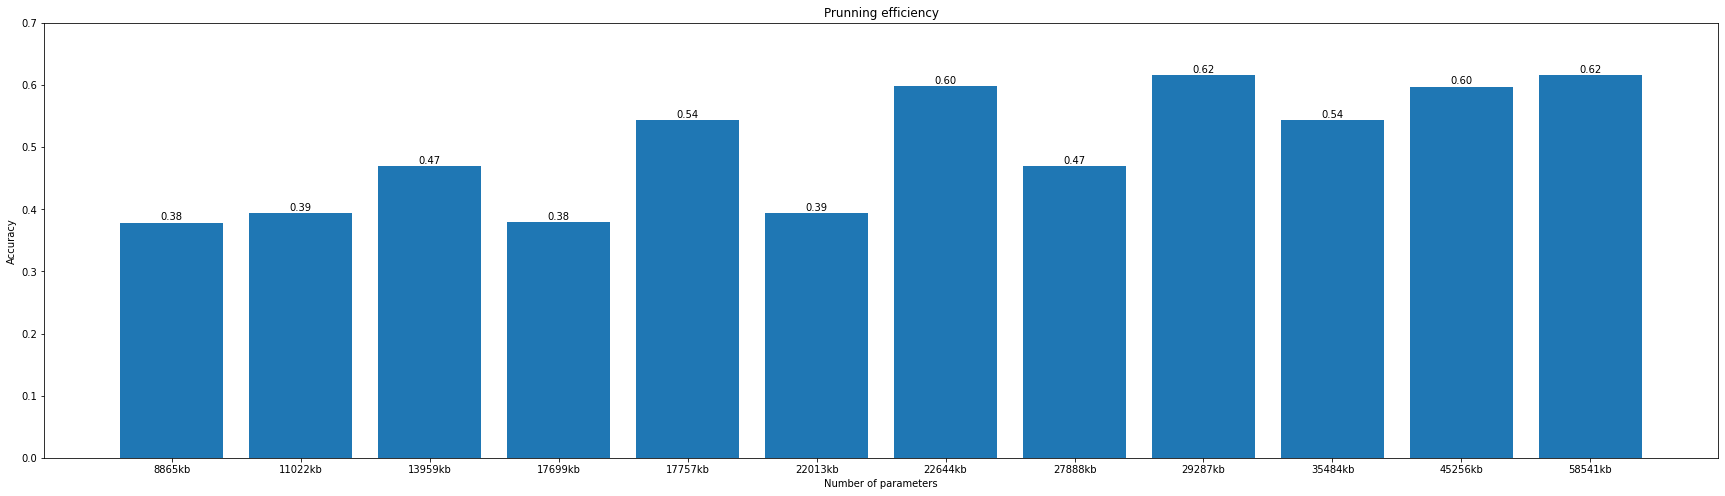

In [52]:
plt.figure(figsize=(30,8))
plot = plt.bar(final_summary['Model size'],
               final_summary['Accuracy'])
for value in plot:
    height = value.get_height()
    plt.text(value.get_x() + value.get_width()/2.,
             1.002*height,'%.2f' % height, ha='center', va='bottom')

axes = plt.gca()
axes.set_ylim([0.0, 0.7])
plt.title("Prunning efficiency")
plt.xlabel("Number of parameters")
plt.ylabel("Accuracy")
plt.show()